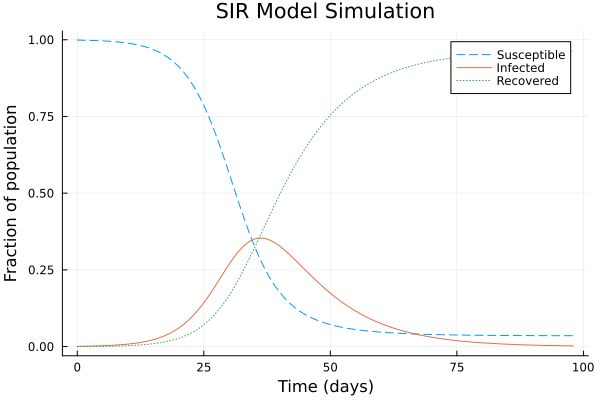

In [9]:
using Plots

# Definiowanie stanu systemu jako krotki
function initial_state()
    s = 999.0
    i = 1.0
    r = 0.0
    total = s + i + r
    s /= total
    i /= total
    r /= total
    return s, i, r
end

# Definiowanie parametrów systemu jako słownik
function make_system()
    tc = 3.0  # czas między kontaktami w dniach
    tr = 10.0  # czas wyzdrowienia w dniach

    beta = 1 / tc  # wskaźnik kontaktów na dzień
    gamma = 1 / tr  # wskaźnik wyzdrowień na dzień

    t_end = 7 * 14  # koniec symulacji w dniach

    return Dict(:beta => beta, :gamma => gamma, :t_end => t_end)
end

# Funkcja aktualizacji stanu
function update_state(s, i, r, system)
    beta = system[:beta]
    gamma = system[:gamma]

    infected = beta * i * s
    recovered = gamma * i

    s -= infected
    i += infected - recovered
    r += recovered

    return s, i, r
end

# Symulacja modelu SIR
function run_simulation(system, update_func)
    s, i, r = initial_state()
    t_end = system[:t_end]

    S = [s]
    I = [i]
    R = [r]

    for t in 1:t_end
        s, i, r = update_func(s, i, r, system)
        push!(S, s)
        push!(I, i)
        push!(R, r)
    end

    return S, I, R
end

# Funkcja rysująca wyniki symulacji
function plot_results(S, I, R)
    plot(0:length(S)-1, S, label="Susceptible", linestyle=:dash)
    plot!(0:length(I)-1, I, label="Infected")
    plot!(0:length(R)-1, R, label="Recovered", linestyle=:dot)
    xlabel!("Time (days)")
    ylabel!("Fraction of population")
    title!("SIR Model Simulation")
    #grid!(true)
end

# Główna część programu
system = make_system()
S, I, R = run_simulation(system, update_state)
plot_results(S, I, R)
